#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 169 # [m]
Xg = 78 # [m]
mn = 123000000 # mass of the vessel, [kg]  Solitaire type vessel 
kp, kd=1.95e4,1.5e4

In [8]:
vessel_mass=mn/L # mass over length of the vessel

In [9]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [10]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [11]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [12]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [13]:
Irho+=vessel_inertia

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [15]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [16]:
E = 210e9

In [17]:
E*Ar

16991625880.187403

In [18]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [19]:
DT=np.diag(diag_DT) # (35) in [2]

In [20]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [21]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [22]:
CT=np.diag(diag_CT)

In [23]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [24]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [25]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [26]:
rng = np.random.default_rng()

In [27]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [28]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [29]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.88493018,  0.26559341, -0.38256858],
       [ 0.03091127,  0.78614278,  0.61727143],
       [ 0.46469675, -0.5580678 ,  0.68747164]])

In [30]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.005677


In [31]:
Ret.shape

(50, 3, 3)

In [32]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [33]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [34]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000541


In [35]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [36]:
fD(dx,dy,dz,DT,Ret).T

array([[-3.65452146e+04,  1.86057916e+04,  2.25800132e+04],
       [ 1.51521631e+04,  4.44296965e+03,  2.64462915e+04],
       [ 3.22857437e+03,  1.17481294e+04, -3.03110006e+03],
       [ 2.35993108e+03, -1.02347105e+04, -4.47466453e+03],
       [-1.07912277e+04,  6.41058032e+03, -1.81118224e+04],
       [ 9.34032052e+02,  9.40817341e+03, -4.38342796e+03],
       [-5.00187618e+03, -1.86313576e+04, -5.15401681e+02],
       [ 1.24964943e+03, -7.06593701e+03,  8.49613375e+03],
       [-1.42207596e+03,  1.07771225e+04, -6.88244515e+03],
       [ 8.53959552e+03, -1.81963032e+03, -1.97508023e+04],
       [ 5.41008112e+03,  1.79866476e+03, -1.99486743e+04],
       [-4.69481995e+03,  4.95273760e+03,  1.69965936e+04],
       [-4.01615939e+03, -2.91693398e+03,  3.64027367e+03],
       [ 1.34680211e+04, -4.68956105e+02, -9.58207562e+01],
       [-1.52285792e+03, -6.12618050e+03, -5.74895427e+02],
       [ 3.08444642e+03, -2.62910531e+04,  4.25710241e+04],
       [-3.66962550e+03,  6.57869280e+03

In [37]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000273


In [38]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [39]:
I=np.identity(3)

In [40]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.001093


In [41]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [42]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [43]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [44]:
DR=np.diag(diag_DR) 

In [45]:
Ar

0.08091250419136858

In [46]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [47]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [48]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [49]:
def Re_b(Ret):
    return Ret

In [50]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000120


In [51]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float32),B.T.astype(np.float32))

In [52]:
phi(x,y,z,Ret,None)

array([[ 3.04869086e-01, -1.81315422e-01, -1.20756292e+00],
       [-3.97015363e-01, -6.40152812e-01, -7.82889947e-02],
       [-7.23286271e-01, -6.04246259e-01,  1.30675411e+00],
       [-2.27657259e-02, -1.15302646e+00,  9.64695871e-01],
       [ 1.00665724e+00,  1.20293510e+00, -6.13117635e-01],
       [ 1.11686718e+00,  9.21182036e-01, -1.15041280e+00],
       [-2.11255282e-01,  8.64792347e-01, -2.35279143e-01],
       [-9.43773091e-01, -4.77267236e-01, -2.64157981e-01],
       [ 8.84077430e-01, -2.78804988e-01,  1.93103075e+00],
       [-6.93288088e-01, -1.12669595e-01,  1.74691844e+00],
       [-1.63207817e+00, -1.79661369e+00,  3.61234099e-01],
       [-1.48945475e+00, -8.11817884e-01,  4.91205752e-01],
       [ 1.77095127e+00,  5.65576434e-01, -7.85430491e-01],
       [-8.29988360e-01,  1.18865483e-01,  7.48390377e-01],
       [ 6.10840321e-01, -1.49881852e+00,  8.74584496e-01],
       [-4.65063006e-01, -1.70634854e+00, -1.32943106e+00],
       [ 9.40596238e-02, -4.26466942e-01

In [53]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000622


In [54]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [55]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [56]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.003517


In [57]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [58]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.002697


In [59]:
ωe(φ,θ,ψ,None,None)

array([[-0.59298785, -0.5873749 , -0.4803546 ],
       [-1.0862216 ,  0.31386013,  0.66097093],
       [ 0.70567865,  2.65898134,  0.11984972],
       [ 0.60343871,  0.881872  , -0.69077165],
       [-0.01449225, -0.61575246, -0.13944561],
       [ 0.57581038,  1.84963145,  0.37622202],
       [-0.3333983 , -0.66761415, -0.49267691],
       [ 0.03979521, -0.60878789, -1.76831912],
       [ 0.3190484 ,  1.22179434, -0.8504494 ],
       [ 0.60009626,  0.84588846, -0.69691863],
       [ 1.25958758, -0.74497956,  0.58618075],
       [ 0.70514191,  0.1879682 , -1.66402981],
       [ 1.46710807,  0.23455432,  0.70181114],
       [-0.48081956,  0.72895987,  0.18556882],
       [ 0.51583736, -1.86920767,  0.74291152],
       [-1.97607724,  1.0696575 , -0.93759665],
       [-0.15806838, -0.32732567, -1.3662118 ],
       [-0.41019893,  0.13499388, -0.25406038],
       [ 0.53146171,  0.05291837,  0.49400731],
       [-2.43186998, -3.07658924, -0.7825173 ],
       [-0.40190805,  0.12835564, -0.664

In [60]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
  
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float32)).T

In [61]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [62]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-1.02623721e-05,  5.61858184e-06,  1.91098121e-05,
         2.11770110e-05, -1.81603453e-05, -2.07157407e-05,
        -1.10006046e-05,  2.13107118e-06,  2.20981358e-05,
         1.85956939e-05,  2.15782616e-05,  1.30301057e-05,
        -1.35099338e-05,  6.29518583e-06,  2.37337922e-05,
         3.76913703e-06,  1.80738604e-05, -3.25293975e-05,
        -3.19854540e-06,  1.86865990e-05,  3.86228147e-06,
         6.89132456e-07, -1.00499111e-05, -9.71001844e-06,
        -1.34132936e-05,  1.36840227e-05, -8.07642082e-06,
        -4.80213544e-06,  2.82525163e-05,  2.05719691e-05,
        -3.17622624e-05,  4.70919448e-06,  1.00992362e-05,
        -4.09464248e-06,  2.58842466e-06, -6.40816672e-06,
        -6.54846481e-06, -9.29876631e-06,  1.51209865e-06,
        -3.52304861e-06,  2.62944434e-05, -5.98491406e-06,
        -2.04334878e-06,  1.69513413e-05,  1.70695357e-05,
        -2.04028707e-05, -1.74126101e-05,  9.62561405e-06,
        -6.39509005e-06, -1.43995868e-05],
       [ 1.51

In [63]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.005686


In [64]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [65]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [66]:
d_s(ne,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-2.00520871e+02,  2.63281073e+02,  3.08721516e+02,
         2.65401342e+02, -4.38385697e+02,  1.98716119e+02,
        -3.35672231e+02, -2.18729459e+02,  3.02188897e+02,
         1.74129649e+02, -3.76127953e+01,  1.69685966e+02,
        -2.37409538e+01, -1.47760540e+02, -2.00517207e+02,
        -3.87147908e+02, -2.34550969e+02, -2.15764128e+02,
         2.85346734e+02,  4.49063110e+02, -2.69707446e+02,
         3.59204624e+02,  2.71822127e+02,  2.89888781e+02,
         8.96979506e+01,  5.67392501e+01, -3.20571929e+02,
        -1.09431730e+01,  2.36705899e+02,  1.62238321e+02,
        -2.31182251e+01, -2.28012796e+01, -4.68942298e+02,
        -3.53260854e+02, -1.74255537e+02,  3.48645390e+02,
         2.12769047e+02,  3.07463908e+02,  3.21299422e+02,
         1.78751051e+02,  3.11423360e+02,  4.43782755e+01,
        -3.34699936e+02,  9.49046089e+01, -2.78508401e+02,
        -3.84359181e+02,  2.29901907e+01,  2.67753192e+02,
         5.72579096e+01,  1.79669116e+02],
       [-4.73

In [67]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 7.43160367e-07,  1.06828475e-06,  2.05252990e-06,
         1.61686792e-06, -2.19064874e-06,  5.64988643e-07,
        -1.34588667e-06, -9.81788575e-07,  2.53354099e-06,
         2.00676991e-06,  6.74340407e-07, -1.34459116e-06,
        -4.81086964e-07, -1.81160626e-07,  3.45227611e-07,
        -1.24524945e-07,  5.55802086e-07,  5.74513450e-07,
         1.43108448e-08,  2.06452008e-06, -2.20604167e-06,
         2.34242365e-06,  7.69328955e-07, -1.08423252e-06,
        -1.35569845e-06, -3.66754581e-07,  9.50700045e-07,
         7.89399950e-07,  1.34650751e-07,  2.14560800e-06,
        -2.56082740e-06,  1.47956312e-07,  6.75091961e-07,
        -3.61755306e-07,  2.41306063e-07,  4.18886122e-07,
        -8.23100010e-07,  1.96996968e-07, -9.36286166e-07,
         2.04945252e-06, -7.20091217e-07, -3.73222633e-07,
        -6.16849966e-07,  3.49735732e-06,  2.58351454e-06,
         9.11512508e-07, -2.26545697e-06,  9.38741220e-08,
         8.52467755e-08, -1.98112599e-06],
       [ 5.51

In [68]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [69]:
ne_(dx,dy,dz,DT,Ret)

array([[ 3.65452146e+04, -1.51521631e+04, -3.22857437e+03,
        -2.35993108e+03,  1.07912277e+04, -9.34032052e+02,
         5.00187618e+03, -1.24964943e+03,  1.42207596e+03,
        -8.53959552e+03, -5.41008112e+03,  4.69481995e+03,
         4.01615939e+03, -1.34680211e+04,  1.52285792e+03,
        -3.08444642e+03,  3.66962550e+03,  7.63243630e+03,
        -1.50921518e+04, -8.90495493e+02, -5.66948037e+04,
        -3.91199592e+03,  2.03419446e+02,  8.52457421e+02,
         1.46634288e+03,  1.72648016e+04,  9.41657400e+03,
         2.98920381e+03, -4.84436295e+03, -2.32360543e+04,
        -2.75909644e+03,  8.54427233e+03,  2.47335042e+02,
         4.72658108e+03,  4.68663200e+03, -1.01776062e+04,
        -2.40190040e+03,  2.68518930e+03,  6.01543658e+03,
        -1.51952566e+04,  6.27191318e+03, -7.28949077e+03,
        -8.26132766e+03, -3.46910941e+03,  7.26436649e+01,
         4.34202002e+04, -3.82482645e+03, -8.71561719e+02,
        -1.48958614e+03, -2.05255948e+03],
       [-1.86

In [70]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.006157


In [71]:
d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T

array([[ 1.67521279e+07,  9.03785607e+08, -1.31473946e+08],
       [-1.61956632e+08,  1.00302162e+08,  1.15673964e+06],
       [-1.26570553e+08,  5.59165721e+08,  1.88502986e+08],
       [-9.79629153e+07, -4.40192109e+08, -5.28439441e+08],
       [-4.29224207e+08,  7.21567460e+08,  7.10984552e+08],
       [-2.25550462e+08, -1.69639376e+06, -2.20331865e+08],
       [-2.66735587e+08,  6.85991019e+07,  4.91642730e+08],
       [ 9.72527945e+07, -1.78056873e+08, -2.57567789e+07],
       [ 2.77920255e+08, -4.88977319e+08, -1.97838558e+08],
       [-1.49372941e+08, -6.02005544e+08, -9.81077293e+07],
       [ 1.17562725e+07, -2.53234122e+08, -1.20635548e+09],
       [-2.63925129e+08,  4.05868133e+08, -1.29504851e+08],
       [ 2.07922940e+07,  2.90863415e+08,  2.56327753e+08],
       [-2.29313331e+08, -3.99343077e+07, -2.47972971e+08],
       [-1.72545156e+07,  7.79714585e+07,  1.45674683e+08],
       [ 5.53514228e+08, -6.94910594e+07, -1.04437926e+08],
       [ 4.12882324e+07,  1.09538691e+07

In [72]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-6.92990912e+08, -1.91028635e+07, -2.19623936e+08],
       [-5.46016122e+06, -1.17176570e+07,  2.51563672e+08],
       [ 2.74399332e+08, -3.13844188e+07,  2.77337422e+08],
       [-4.60244929e+08, -9.82437866e+07,  1.67157829e+08],
       [-5.45827277e+08,  5.40331442e+07, -3.84353007e+08],
       [ 4.15562500e+04, -1.97240244e+08,  1.47607858e+06],
       [-5.73740345e+08,  2.14095276e+07, -3.14263051e+08],
       [ 1.22846130e+07,  3.35035974e+07, -1.85226085e+08],
       [-1.89903742e+08, -1.63891646e+08,  1.38297560e+08],
       [-4.41405489e+08,  6.97743687e+07,  2.43904191e+08],
       [-6.47959881e+08,  2.58680824e+07, -1.17447507e+07],
       [ 1.81307297e+07,  9.68296040e+07,  2.66515748e+08],
       [-3.73905128e+08,  2.53291114e+07,  1.58813437e+06],
       [-2.62525586e+08,  3.36363087e+08,  1.88602385e+08],
       [ 4.26236249e+07,  1.33897538e+08, -6.66198739e+07],
       [ 1.62346618e+07,  2.84133573e+08, -1.03014726e+08],
       [-5.83003013e+06,  3.24995554e+07

In [73]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000368


In [74]:
Re_b(Ret).shape

(50, 3, 3)

In [75]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans


In [76]:
Irho_e(Ret).shape

(50, 3, 3)

In [77]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000166


In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega)
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.005067


In [82]:
d_me_

array([[ 7.83139352e-14,  2.86530264e-09, -2.19122295e-09],
       [ 3.10093211e-15,  6.42953610e-11, -2.30942750e-09],
       [ 4.22288126e-14,  3.84445476e-09, -1.69379596e-09],
       [ 5.96139430e-14,  2.58139488e-09, -1.26938205e-09],
       [ 6.67919113e-14,  4.59643003e-09, -3.10609763e-09],
       [ 1.19985643e-16,  4.43817475e-09, -6.99808475e-12],
       [ 6.90500890e-14,  3.72602576e-09, -2.62190168e-09],
       [ 5.32429061e-15,  1.63215503e-10, -4.23935800e-09],
       [ 3.30403383e-14,  3.30136785e-09, -8.16538304e-10],
       [ 5.79758166e-14,  2.43842201e-09, -1.78205677e-09],
       [ 7.48836797e-14,  4.23653437e-10, -1.31657879e-10],
       [ 6.90181216e-15,  4.90261742e-10, -4.06291186e-09],
       [ 5.19032767e-14,  4.03819821e-10, -1.16945474e-11],
       [ 4.10017518e-14,  2.81841755e-09, -1.64127851e-09],
       [ 1.22026078e-14,  6.85787571e-10, -1.27626776e-09],
       [ 6.41184140e-15,  1.63829164e-09, -8.87910843e-10],
       [ 3.23944886e-15,  1.56846790e-10

In [83]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [84]:
ne_(dx,dy,dz,DT,Ret)

array([[ 3.65452146e+04, -1.51521631e+04, -3.22857437e+03,
        -2.35993108e+03,  1.07912277e+04, -9.34032052e+02,
         5.00187618e+03, -1.24964943e+03,  1.42207596e+03,
        -8.53959552e+03, -5.41008112e+03,  4.69481995e+03,
         4.01615939e+03, -1.34680211e+04,  1.52285792e+03,
        -3.08444642e+03,  3.66962550e+03,  7.63243630e+03,
        -1.50921518e+04, -8.90495493e+02, -5.66948037e+04,
        -3.91199592e+03,  2.03419446e+02,  8.52457421e+02,
         1.46634288e+03,  1.72648016e+04,  9.41657400e+03,
         2.98920381e+03, -4.84436295e+03, -2.32360543e+04,
        -2.75909644e+03,  8.54427233e+03,  2.47335042e+02,
         4.72658108e+03,  4.68663200e+03, -1.01776062e+04,
        -2.40190040e+03,  2.68518930e+03,  6.01543658e+03,
        -1.51952566e+04,  6.27191318e+03, -7.28949077e+03,
        -8.26132766e+03, -3.46910941e+03,  7.26436649e+01,
         4.34202002e+04, -3.82482645e+03, -8.71561719e+02,
        -1.48958614e+03, -2.05255948e+03],
       [-1.86

### Static solution

In [85]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [86]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [87]:
Fx_0=82945396

In [88]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [89]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [90]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [91]:
delta_x=horizontal_length/(node_N-1)

In [92]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [93]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [94]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

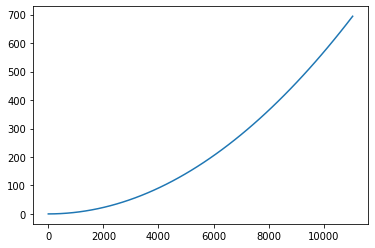

In [95]:
plt.plot(x0, z0)
plt.show()

In [96]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [97]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [98]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T

############################################################    

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [99]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [100]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [101]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [103]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [104]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [105]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [106]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

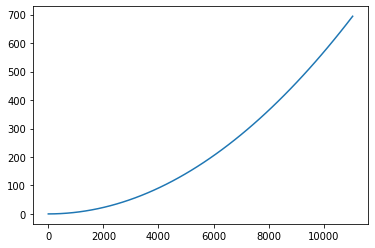

In [107]:
plt.plot(x0_, z0_)
plt.show()

In [108]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_

In [109]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

### Vessle Simulation

In [110]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [111]:
vehicle=semisub('DPcontrol',2,2,40.0,0,0) 

In [112]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [113]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

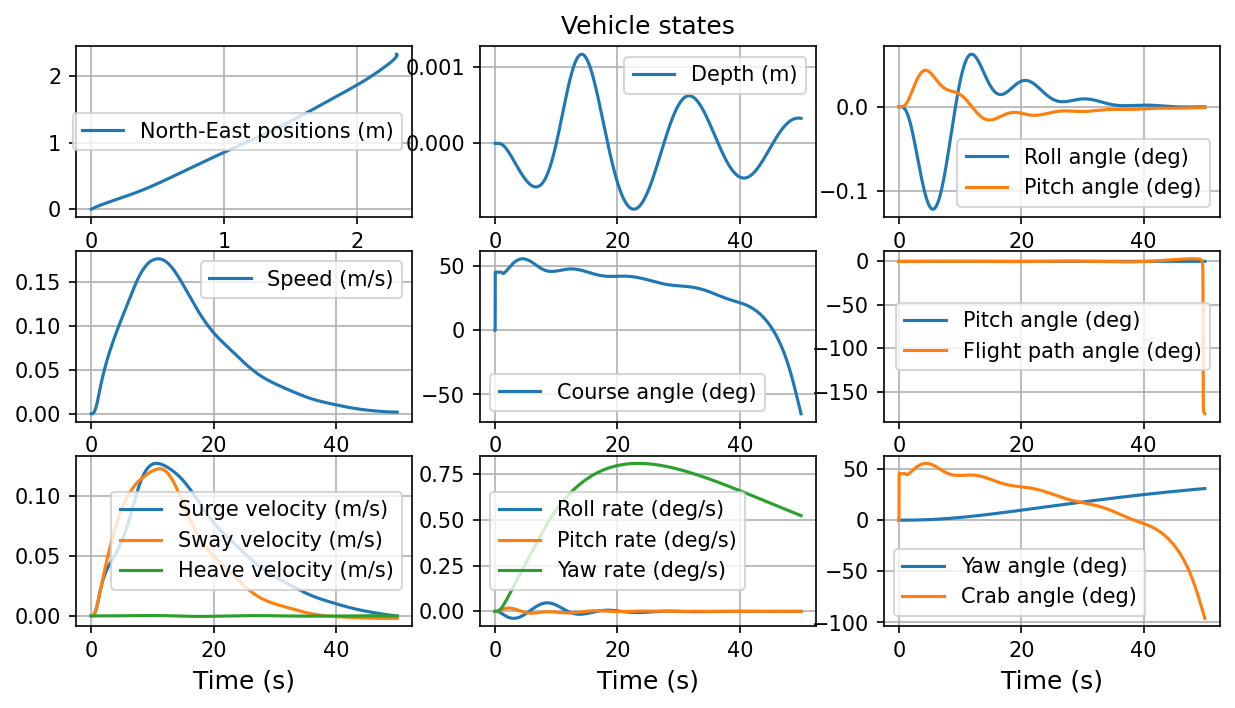

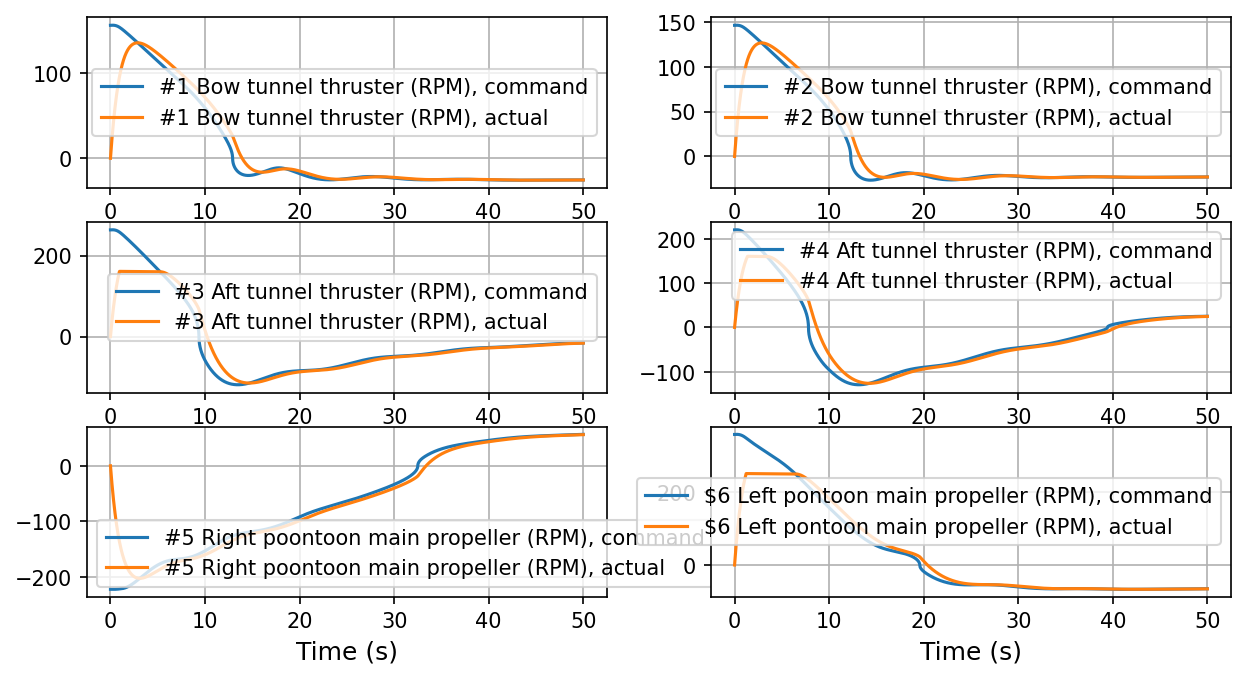

In [114]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [115]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

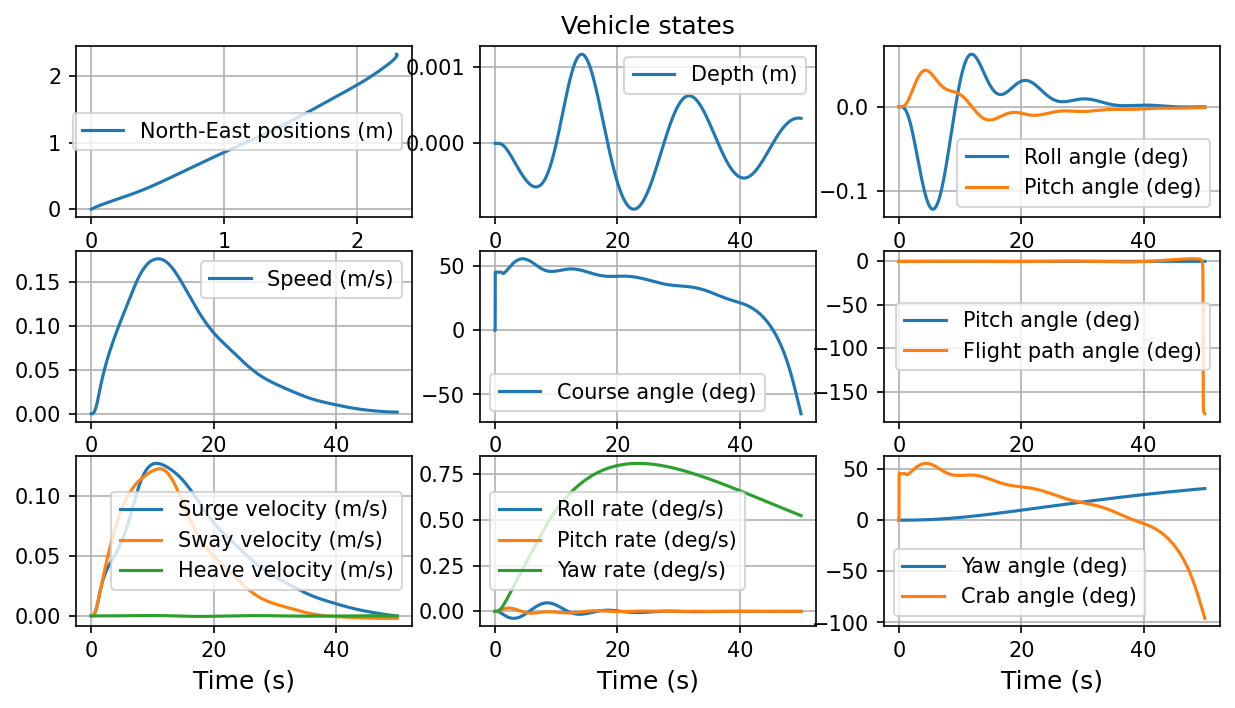

In [116]:
plotVehicleStates(simTime, simData, 3)

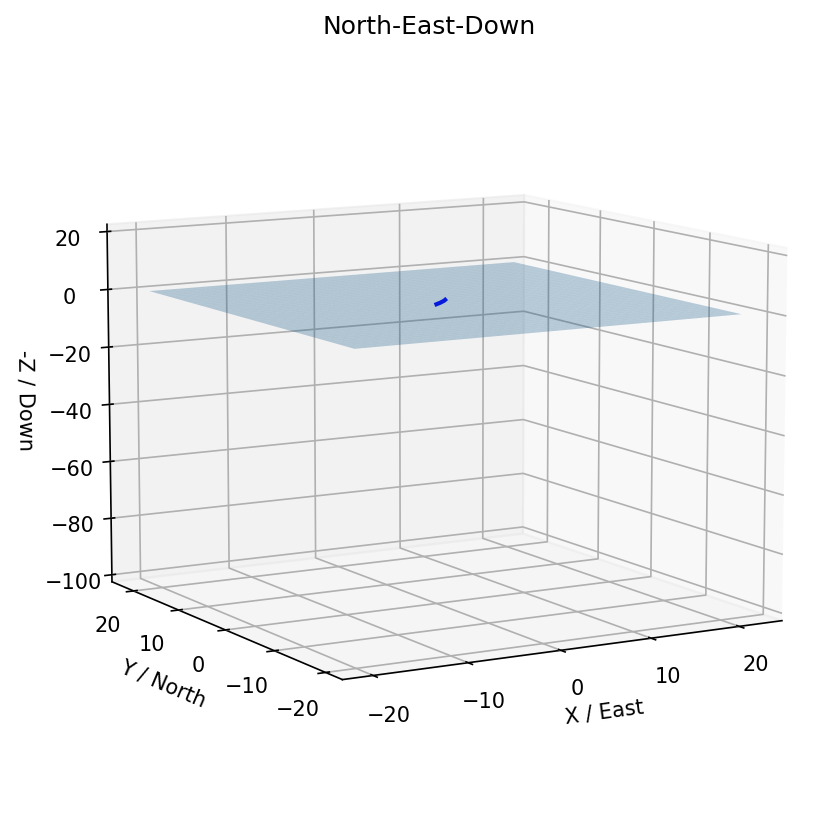

In [117]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [118]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Dynamics

In [122]:
def grayscott1d(t, Q):
    print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
    n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
    force_schedule = 1
    tau_force = force_schedule*0.0166666667*n_ # [N]

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)
    
    Z0=np.dot(Re_b(Ret),tau_force[:3])   
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T

    Z= (Z1 + Z2 +Z0)

############################################################    

    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N-1)]
                                             +[vessel_mass]
                                             ,RRRR),
                                   Z).T 
############################################################      

    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None))
    
    C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
#     C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None)))

#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [123]:
tspan = (0., 15)

In [124]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0.0
0.00010881028720341658
0.0021762057440683313
0.003264308616102497
0.008704822976273325
0.009672025529192583
0.010881028720341657
0.010881028720341657
0.027192269260729394
0.035347889530923264
0.0761259908818926
0.08337543112206493
0.09243723142228034
0.09243723142228034
0.18025177721888813
0.224159050117192
0.44369541460871154
0.48272410162942603
0.5315099604053193
0.5315099604053193
0.7604320167117108
0.8748930448649065
1.4471981856308853
1.5489413217670591
1.6761202419372767
1.6761202419372767
0.7038461450461504
0.790014237366566
1.2208546989686437
1.297448558809013
1.3931908836094749
1.3931908836094749
1.565527068250306
1.6516951605707215
2.0825356221727995
2.159129482013169
2.2548718068136306
2.2548718068136306
2.431096827369668
2.519209337647687
2.959771889037781
3.03809412039602
3.1359969095938185
3.1359969095938185
3.3618174664146823
3.4747277448251137
4.039279136877273
4.139643828797657
4.2650996936981365
4.2650996936981365
4.561368476355736
4.709502867684536
5.450174824328

### Results

In [125]:
fin=us

In [126]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 98
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.08810287e-02, 9.24372314e-02, 5.31509960e-01,
       1.39319088e+00, 2.25487181e+00, 3.13599691e+00, 4.26509969e+00,
       5.74644361e+00, 7.77758843e+00, 9.80891222e+00, 1.18402360e+01,
       1.34507490e+01, 1.50000000e+01])
 t_events: None
        y: array([[0.00000000e+00, 2.11271586e-07, 1.52493499e-05, ...,
        1.58491206e-01, 1.88515557e-01, 2.17156626e-01],
       [2.25564997e+02, 2.25564997e+02, 2.25565012e+02, ...,
        2.25723488e+02, 2.25753512e+02, 2.25782153e+02],
       [4.51129994e+02, 4.51129994e+02, 4.51130009e+02, ...,
        4.51288485e+02, 4.51318509e+02, 4.51347150e+02],
       ...,
       [0.00000000e+00, 8.65929091e-14, 7.06601868e-13, ...,
        5.32907210e-12, 5.04854155e-12, 4.87495039e-12],
       [0.00000000e+00, 8.65929091e-14, 7.06601868e-13, ..

In [127]:
t=fin.t

In [128]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


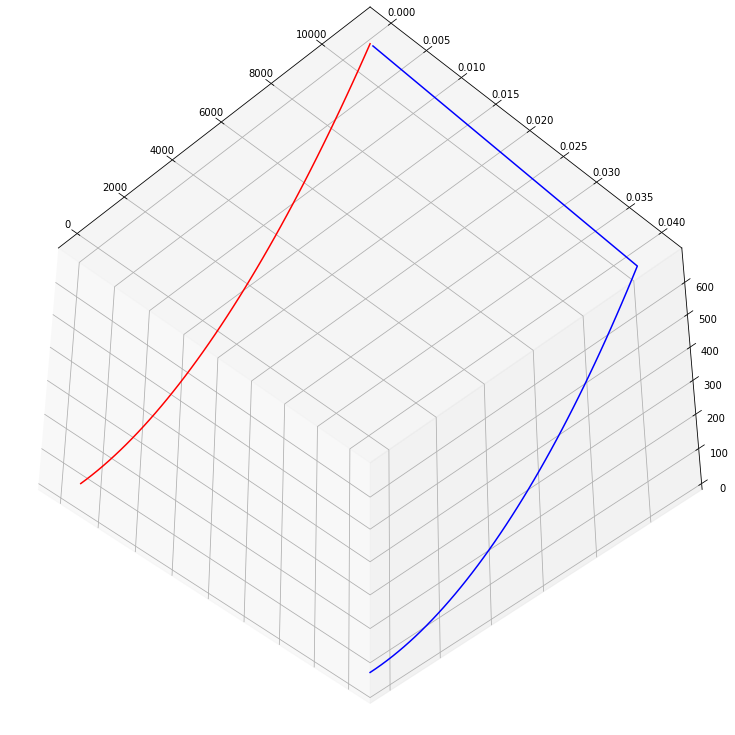

In [129]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [130]:
X,Y,Z

(array([2.17156626e-01, 2.25782153e+02, 4.51347150e+02, 6.76912147e+02,
        9.02477144e+02, 1.12804214e+03, 1.35360714e+03, 1.57917213e+03,
        1.80473713e+03, 2.03030213e+03, 2.25586712e+03, 2.48143212e+03,
        2.70699712e+03, 2.93256212e+03, 3.15812711e+03, 3.38369211e+03,
        3.60925711e+03, 3.83482210e+03, 4.06038710e+03, 4.28595210e+03,
        4.51151709e+03, 4.73708209e+03, 4.96264709e+03, 5.18821208e+03,
        5.41377708e+03, 5.63934208e+03, 5.86490707e+03, 6.09047207e+03,
        6.31603707e+03, 6.54160206e+03, 6.76716706e+03, 6.99273206e+03,
        7.21829706e+03, 7.44386205e+03, 7.66942705e+03, 7.89499205e+03,
        8.12055704e+03, 8.34612204e+03, 8.57168704e+03, 8.79725203e+03,
        9.02281703e+03, 9.24838203e+03, 9.47394702e+03, 9.69951202e+03,
        9.92507702e+03, 1.01506420e+04, 1.03762070e+04, 1.06017720e+04,
        1.08273370e+04, 1.10526853e+04]),
 array([0.04021587, 0.04021587, 0.04021587, 0.04021587, 0.04021587,
        0.04021587, 0.0402

In [131]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [132]:
us=fin.T

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()